
Training Random Forest...

Training XGBoost...

Training DNN...


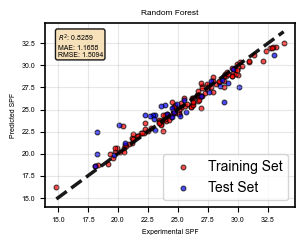

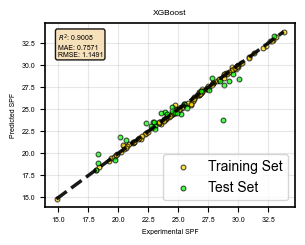

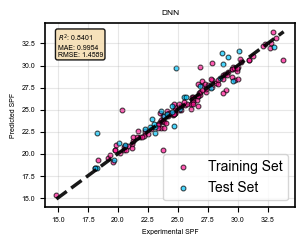


========== Starting SHAP Analysis for Synergistic Effects ==========


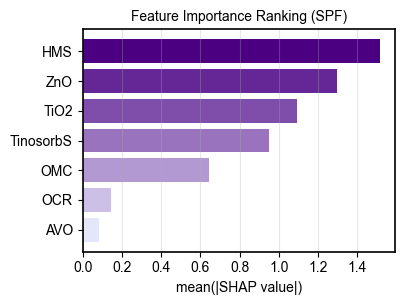

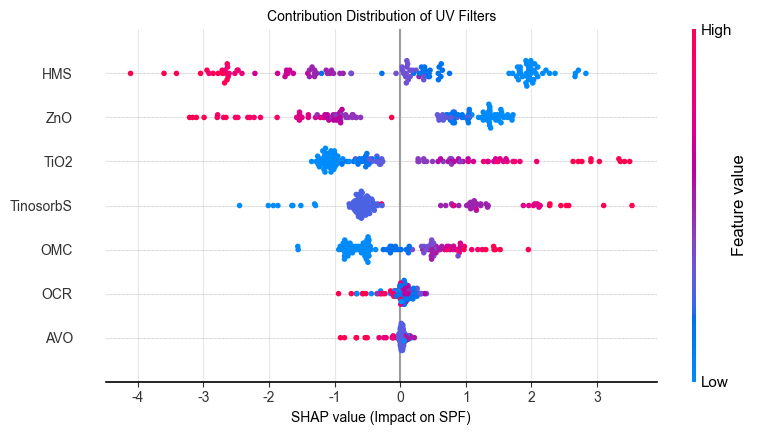

<Figure size 400x300 with 0 Axes>

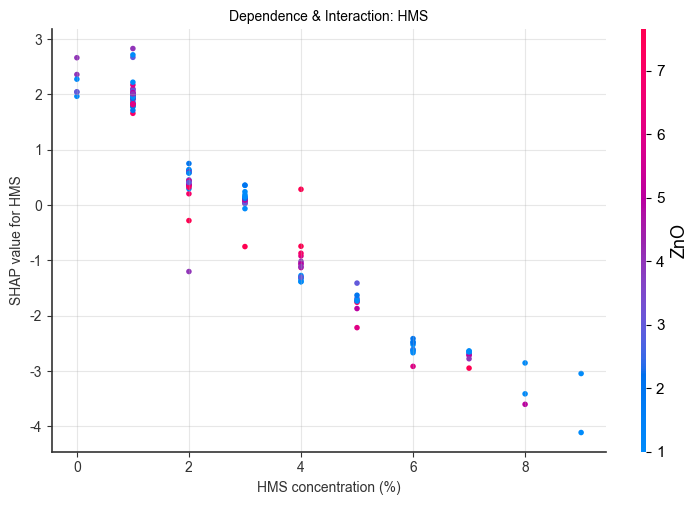

<Figure size 400x300 with 0 Axes>

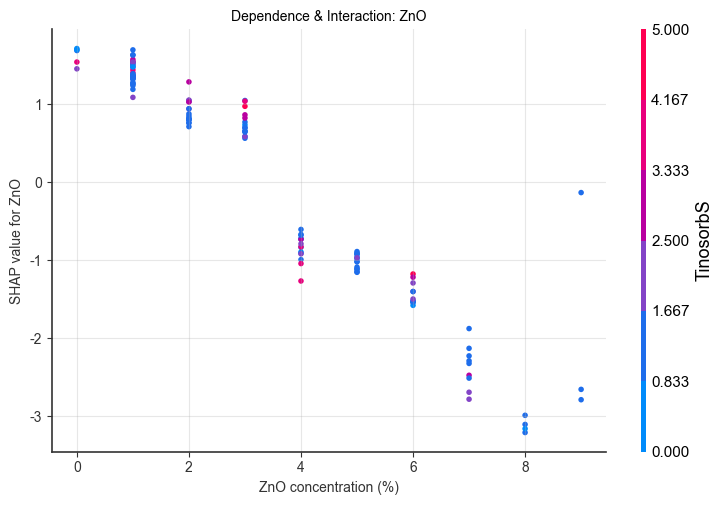

<Figure size 400x300 with 0 Axes>

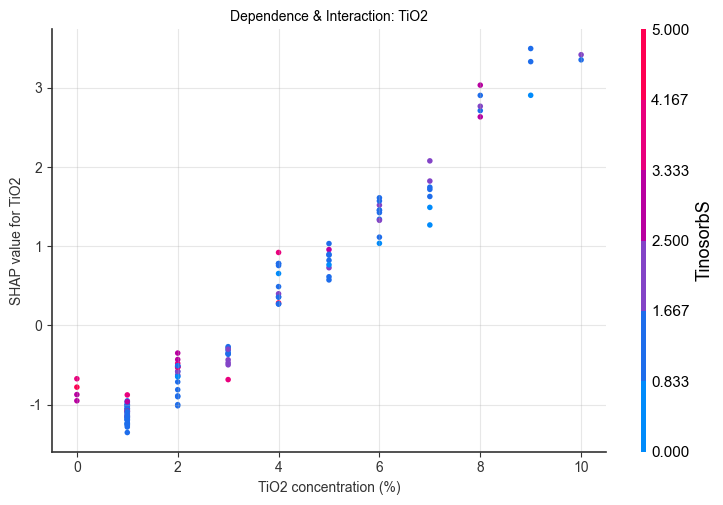


========== All Analysis Completed Successfully ==========


<Figure size 500x400 with 0 Axes>

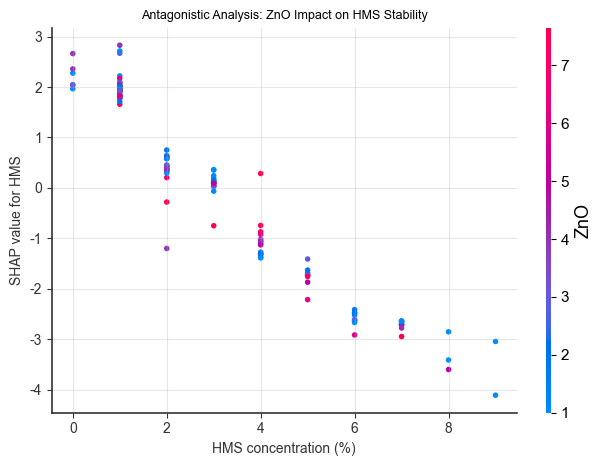

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import shap  
import matplotlib.colors as mcolors 

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

class GlobalParams:
    DATA_FILE_PATH = r"D:\桌面\sci论文\new\160组\数据\SPF.xlsx"
    TEST_SIZE = 0.2
    RANDOM_SEED = 32
    FEATURE_NAMES = ['OMC', 'HMS', 'OCR', 'TiO2', 'AVO', 'TinosorbS', 'ZnO']
    

    PLOT_DPI = 300
    PLOT_FIGSIZE = (3, 2.4)
    PLOT_FONT = 'Arial'
    SCATTER_SIZE = 12
    ALPHA = 0.7
    FONT_SIZE = 5
    LEGEND_FONT_SIZE = 5

class ModelColor:
    RF_TRAIN = '#FF0000'; RF_TEST = '#0000FF'
    XGB_TRAIN = '#FFD700'; XGB_TEST = '#00FF00'
    DNN_TRAIN = '#FF1493'; DNN_TEST = "#00C8FF"

class RFParams:
    n_estimators = 150; criterion = 'poisson'; max_depth = 10; min_samples_split = 2
    min_samples_leaf = 1; min_weight_fraction_leaf = 0.0; max_features = 1.0
    max_leaf_nodes = None; min_impurity_decrease = 0.0; bootstrap = True
    oob_score = False; n_jobs = -1; random_state = GlobalParams.RANDOM_SEED
    verbose = 0; warm_start = False; ccp_alpha = 0.0; max_samples = None

class XGBParams:
    booster = 'dart'; n_estimators = 250; learning_rate = 0.2; max_depth = 3
    min_child_weight = 1; gamma = 0.0; subsample = 1.0; colsample_bytree = 1.0
    colsample_bylevel = 1.0; colsample_bynode = 1.0; reg_alpha = 0.0
    reg_lambda = 1.0; scale_pos_weight = 1.0; base_score = 0.5
    random_state = GlobalParams.RANDOM_SEED; objective = 'reg:squarederror'
    eval_metric = 'rmse'; seed = GlobalParams.RANDOM_SEED; verbosity = 0
    n_jobs = -1; importance_type = 'gain'

class DNNParams:
    hidden_layer_sizes = (128,64, 32, 16); activation = 'relu'; solver = 'adam'
    alpha = 0.01; batch_size = 'auto'; learning_rate = 'adaptive'
    learning_rate_init = 0.01; power_t = 0.5; max_iter = 2000; shuffle = True
    random_state = GlobalParams.RANDOM_SEED; tol = 1e-4; verbose = False
    warm_start = False; momentum = 0.9; nesterovs_momentum = True
    early_stopping = True; validation_fraction = 0.1; beta_1 = 0.9
    beta_2 = 0.999; epsilon = 1e-8; n_iter_no_change = 20; max_fun = 15000

plt.rcParams.update({
    'font.family': GlobalParams.PLOT_FONT,   
    'font.size': GlobalParams.FONT_SIZE,      
    'axes.linewidth': 1.2,                    
    'lines.linewidth': 1.5,                   
    'savefig.dpi': GlobalParams.PLOT_DPI,     
    'savefig.bbox': 'tight',                 
    'axes.facecolor': 'white',               
    'figure.facecolor': 'white',            
    'axes.unicode_minus': False,               
    'legend.fontsize': GlobalParams.LEGEND_FONT_SIZE+5, 
    'scatter.edgecolors': 'black'           
})

model_color_map = {
    'Random Forest': (ModelColor.RF_TRAIN, ModelColor.RF_TEST),
    'XGBoost': (ModelColor.XGB_TRAIN, ModelColor.XGB_TEST),
    'DNN': (ModelColor.DNN_TRAIN, ModelColor.DNN_TEST)
}

df = pd.read_excel(GlobalParams.DATA_FILE_PATH)
X = df[GlobalParams.FEATURE_NAMES].values
y = df['SPF'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=GlobalParams.TEST_SIZE, 
    random_state=GlobalParams.RANDOM_SEED, shuffle=True
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
models = {
    'Random Forest': RandomForestRegressor(**{k:v for k,v in RFParams.__dict__.items() if not k.startswith('__')}),
    'XGBoost': XGBRegressor(**{k:v for k,v in XGBParams.__dict__.items() if not k.startswith('__')}),
    'DNN': MLPRegressor(**{k:v for k,v in DNNParams.__dict__.items() if not k.startswith('__')})
}

predictions = {}; metrics = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    predictions[name] = (y_train_pred, y_test_pred)
    metrics[name] = {
        'test_r2': r2_score(y_test, y_test_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
    }
for name in models.keys():
    plt.figure(figsize=GlobalParams.PLOT_FIGSIZE)
    y_train_pred, y_test_pred = predictions[name]
    m = metrics[name]; train_color, test_color = model_color_map[name]
    plt.scatter(
        y_train, y_train_pred, 
        color=train_color, 
        alpha=GlobalParams.ALPHA, 
        s=GlobalParams.SCATTER_SIZE, 
        label='Training Set',
        edgecolors='black', 
        linewidth=0.8      
    )
    plt.scatter(
        y_test, y_test_pred, 
        color=test_color, 
        alpha=GlobalParams.ALPHA, 
        s=GlobalParams.SCATTER_SIZE, 
        label='Test Set',
        edgecolors='black', 
        linewidth=0.8     
    )
    
    lims = [np.min([y.min(), y_train_pred.min()]), np.max([y.max(), y_train_pred.max()])]
    plt.plot(lims, lims, 'k--', lw=2.5, alpha=0.9)  
    
    textstr = f'$R^2$: {m["test_r2"]:.4f}\nMAE: {m["test_mae"]:.4f}\nRMSE: {m["test_rmse"]:.4f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    plt.gca().text(
        0.05, 0.95, textstr, 
        transform=plt.gca().transAxes, 
        fontsize=GlobalParams.FONT_SIZE, 
        verticalalignment='top', 
        bbox=props
    )
    plt.title(name); plt.xlabel('Experimental SPF'); plt.ylabel('Predicted SPF'); plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3) 
    plt.tight_layout(); plt.show()
print("\n========== Starting SHAP Analysis for Synergistic Effects ==========")

explainer_model = models['XGBoost']
explainer = shap.TreeExplainer(explainer_model)
shap_values = explainer.shap_values(X_train_scaled)
X_display = pd.DataFrame(X_train, columns=GlobalParams.FEATURE_NAMES)
plt.figure(figsize=(4, 3))
shap_importance = np.abs(shap_values).mean(axis=0)
sorted_idx = np.argsort(shap_importance)[::-1] 
sorted_importance = shap_importance[sorted_idx]
sorted_features = [GlobalParams.FEATURE_NAMES[i] for i in sorted_idx]

purple_cmap = mcolors.LinearSegmentedColormap.from_list('purple_gradient', ['#4B0082', '#E6E6FA'])
colors = purple_cmap(np.linspace(0, 1, len(sorted_features))) 

plt.barh(np.arange(len(sorted_features)), sorted_importance, color=colors)
plt.yticks(np.arange(len(sorted_features)), sorted_features, fontsize=GlobalParams.FONT_SIZE+5)

plt.title('Feature Importance Ranking (SPF)', fontsize=GlobalParams.FONT_SIZE+5)
plt.xlabel('mean(|SHAP value|)', fontsize=GlobalParams.FONT_SIZE+5)
plt.xticks(fontsize=GlobalParams.FONT_SIZE+5)
plt.gca().invert_yaxis() 
plt.grid(True, alpha=0.3, axis='x') 
plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 3))
shap.summary_plot(shap_values, X_display, show=False)
plt.title('Contribution Distribution of UV Filters', fontsize=GlobalParams.FONT_SIZE+5)
plt.xlabel('SHAP value (Impact on SPF)', fontsize=GlobalParams.FONT_SIZE+5)
plt.xticks(fontsize=GlobalParams.FONT_SIZE+5)
plt.yticks(fontsize=GlobalParams.FONT_SIZE+5)
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()
top_3_indices = np.argsort(np.abs(shap_values).mean(0))[-3:][::-1]
top_3_features = [GlobalParams.FEATURE_NAMES[i] for i in top_3_indices]

for feat in top_3_features:
    plt.figure(figsize=(4, 3))
    shap.dependence_plot(feat, shap_values, X_display, interaction_index='auto', show=False)
    
    ax = plt.gca()
    ax.set_title(f'Dependence & Interaction: {feat}', fontsize=GlobalParams.FONT_SIZE+5)
    ax.set_xlabel(f'{feat} concentration (%)', fontsize=GlobalParams.FONT_SIZE+5)
    ax.set_ylabel(f'SHAP value for {feat}', fontsize=GlobalParams.FONT_SIZE+5)
    
    
    for text in ax.figure.texts:
        if text.get_text() in GlobalParams.FEATURE_NAMES or '=' in text.get_text():
            text.set_fontsize(GlobalParams.FONT_SIZE + 3)

    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(GlobalParams.FONT_SIZE+5)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    ax.grid(True, alpha=0.3)  
    ax.title.set_fontsize(GlobalParams.FONT_SIZE+5)
    
    plt.tight_layout()
    plt.show()

print("\n========== All Analysis Completed Successfully ==========")
shap_interaction = explainer.shap_interaction_values(X_train_scaled)

idx_hms = GlobalParams.FEATURE_NAMES.index('HMS')
idx_zno = GlobalParams.FEATURE_NAMES.index('ZnO')

plt.figure(figsize=(5, 4))
shap.dependence_plot(
    "HMS", shap_values, X_display, 
    interaction_index="ZnO", 
    show=False
)
ax = plt.gca()
for text in ax.figure.texts:
    if text.get_text() in GlobalParams.FEATURE_NAMES or '=' in text.get_text():
        text.set_fontsize(GlobalParams.FONT_SIZE + 3)

ax.set_title('Antagonistic Analysis: ZnO Impact on HMS Stability', fontsize=9)
ax.set_xlabel('HMS concentration (%)', fontsize=GlobalParams.FONT_SIZE+5)
ax.set_ylabel('SHAP value for HMS', fontsize=GlobalParams.FONT_SIZE+5)
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(GlobalParams.FONT_SIZE+5)
plt.grid(alpha=0.3)  
for spine in ax.spines.values():
    spine.set_linewidth(1.2)
plt.show()